OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

CONTEXTE : Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

**OBJECTIF** : vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

NB : Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)


**TO DO** :
En + : Vous cherchez également à évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.


**CONSEILS** :

L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données / DATA LEAKS). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.

#### Features to predict :

##### Energy Use :

- **SourceEUI(kBtu/sf)** : Source Energy Use Intensity (EUI) is a property's Source Energy Use divided by its gross floor area. Source Energy Use is the annual energy used to operate the property, including losses from generation, transmission, & distribution. Source EUI is measured in thousands of British thermal units (kBtu) per square foot.


- **SiteEnergyUse(kBtu)** : The annual amount of energy consumed by the property from all sources of energy.

- **SteamUse(kBtu)** : The annual amount of district steam consumed by the property on-site, measured in thousands of British thermal units (kBtu).

- **Electricity(kBtu)** : The annual amount of electricity consumed by the property on-site, including electricity purchased from the grid and generated by onsite renewable systems, measured in thousands of British thermal units (kBtu).

- **NaturalGas(kBtu)** : The annual amount of utility-supplied natural gas consumed by the property, measured in thousands of British thermal units (kBtu).

##### Greenhouse Gas Emissions :

- **TotalGHGEmissions** : The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh until the 2016 factor is available. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.


# PART 1 : Cleaning dataset

### Importing libraries

In [1]:
%reset -f

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [2]:
from cleaning import *
from exploration import *
from functions import *

In [3]:
import os, warnings
# warnings.filterwarnings('ignore')
warnings.filterwarnings(action="once")

### 1) Visualizing dataset

#### 1.1) Global statistics

What's in this Dataset?
Rows : 3,376
Columns : 46
Each row is a : Building



source : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

#### Loading dataset

In [4]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

# load raw dataset
path = "./dataset/source/"
filename = "2016_Building_Energy_Benchmarking.csv"

dataset_path = "{}{}".format(path, filename)
#all_data = pd.read_csv("dataset/source/2016_Building_Energy_Benchmarking.csv", sep = ',', encoding = 'utf-8')
raw_data = pd.read_csv(dataset_path)

display(raw_data)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.00,0659000030,7,DOWNTOWN,47.61,-122.34,1927,1.00,12,88434,0,88434,Hotel,Hotel,88434.00,NaN,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.00,0659000220,7,DOWNTOWN,47.61,-122.33,1996,1.00,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,NaN,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.00,0659000475,7,DOWNTOWN,47.61,-122.34,1969,1.00,41,956110,196718,759392,Hotel,Hotel,756493.00,NaN,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.00,0659000640,7,DOWNTOWN,47.61,-122.34,1926,1.00,10,61320,0,61320,Hotel,Hotel,61320.00,NaN,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.00,0659000970,7,DOWNTOWN,47.61,-122.34,1980,1.00,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,NaN,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,False,NaN,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.57,-122.31,1990,1.00,1,12294,0,12294,Office,Office,12294.00,NaN,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.60,-122.32,2004,1.00,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.64,-122.36,1974,1.00,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Cen

In [5]:
# Primary Key : OSEBuilding ID
raw_data["OSEBuildingID"].unique().shape

(3376,)

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
raw_data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.00,3376.00,3360.00,3376.00,3376.00,3376.00,3376.00,3368.00,3376.00,3376.00,3376.00,3376.00,3356.00,1679.00,596.00,2533.00,3369.00,3370.00,3367.00,3367.00,3371.00,3370.00,3367.00,3367.00,3367.00,3367.00,3367.00,0.00,3367.00,3367.00
mean,21208.99,2016.00,98116.95,4.44,47.62,-122.33,1968.57,1.11,4.71,94833.54,8001.53,86832.01,79177.64,28444.08,11738.68,67.92,54.73,57.03,134.23,137.78,5403667.29,5276725.71,274595.90,1086638.97,3707612.16,13685.05,1368504.54,NaN,119.72,1.18
std,12223.76,0.00,18.62,2.12,0.05,0.03,33.09,2.11,5.49,218837.61,32326.72,207939.81,201703.41,54392.92,29331.20,26.87,56.27,57.16,139.29,139.11,21610628.63,15938786.48,3912173.39,4352478.36,14850656.14,67097.81,6709780.83,NaN,538.83,1.82
min,1.00,2016.00,98006.00,1.00,47.50,-122.41,1900.00,0.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,1.00,0.00,0.00,0.00,-2.10,0.00,0.00,0.00,-33826.80,-115417.00,0.00,0.00,NaN,-0.80,-0.02
25%,19990.75,2016.00,98105.00,3.00,47.60,-122.35,1948.00,1.00,2.00,28487.00,0.00,27756.00,25094.75,5000.00,2239.00,53.00,27.90,29.40,74.70,78.40,925128.59,970182.23,0.00,187422.95,639487.00,0.00,0.00,NaN,9.50,0.21
50%,23112.00,2016.00,98115.00,4.00,47.62,-122.33,1975.00,1.00,4.00,44175.00,0.00,43216.00,39894.00,10664.00,5043.00,75.00,38.60,40.90,96.20,101.10,1803753.25,1904452.00,0.00,345129.91,1177583.00,3237.54,323754.00,NaN,33.92,0.61
75%,25994.25,2016.00,98122.00,7.00,47.66,-122.32,1997.00,1.00,5.00,90992.00,0.00,84276.25,76200.25,26640.00,10138.75,90.00,60.40,64.28,143.90,148.35,4222455.25,4381429.12,0.00,829317.84,2829632.50,11890.33,1189033.50,NaN,93.94,1.37
max,50226.00,2016.00,98272.00,7.00,47.73,-122.22,2015.00,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,686750.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,NaN,16870.98,34.09


#### 1.2) Visualizing and cleaning building types

In [8]:
all_data = raw_data.copy()

all_building_types = all_data["BuildingType"].unique().tolist()
print(all_building_types, end='\n\n')

all_primary_types = all_data["PrimaryPropertyType"].unique().tolist()
print(all_primary_types, end='\n\n')

all_largest_property_use_type = all_data["LargestPropertyUseType"].unique().tolist()
print(all_largest_property_use_type, end='\n\n')

['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)', 'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)', 'Multifamily HR (10+)', 'Nonresidential WA']

['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property', 'K-12 School', 'University', 'Small- and Mid-Sized Office', 'Self-Storage Facility', 'Warehouse', 'Large Office', 'Senior Care Community', 'Medical Office', 'Retail Store', 'Hospital', 'Residence Hall', 'Distribution Center', 'Worship Facility', 'Low-Rise Multifamily', 'Supermarket / Grocery Store', 'Laboratory', 'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily', 'Office']

['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly', 'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym', 'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School', 'College/University', 'Automobile Dealership', 'Office', 'Self-Storage Facility', 'Non-Refrigerated Warehouse', 'Other - Mall', 'Senior Care Community', 'Medical Office', 'Retail S

In [9]:
residential_BuildingType = ['Multifamily MR (5-9)', 'Multifamily LR (1-4)', 'Multifamily HR (10+)']
residendial_buildings = all_data[all_data["BuildingType"].isin(residential_BuildingType)]

print("If we remove the buildings which BuildingType is 'Multifamily MR (5-9)', 'Multifamily LR (1-4)' or 'Multifamily HR (10+)', then we lose :", residendial_buildings.shape[0], "which is half of our dataset.")

If we remove the buildings which BuildingType is 'Multifamily MR (5-9)', 'Multifamily LR (1-4)' or 'Multifamily HR (10+)', then we lose : 1708 which is half of our dataset.


In [10]:
print("HERE : mapping property use type")

HERE : mapping property use type


all_data = mapping_property_use_type(all_data, property_use_types_columns, usetype_dict)

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

#### 1.3) Correcting NumberofBuildings

In [12]:
all_data[all_data['NumberofBuildings'] == 0][["BuildingType", "PrimaryPropertyType", "LargestPropertyUseType"]]

,BuildingType,PrimaryPropertyType,LargestPropertyUseType
63,NonResidential,Medical Office,Medical Office
76,NonResidential,Small- and Mid-Sized Office,Office
160,NonResidential,Warehouse,Non-Refrigerated Warehouse
201,NonResidential,Large Office,Office
241,NonResidential,Small- and Mid-Sized Office,Office
...,...,...,...
3184,Multifamily MR (5-9),Mid-Rise Multifamily,Multifamily Housing
3202,Multifamily MR (5-9),Mid-Rise Multifamily,Multifamily Housing
3205,NonResidential,Laboratory,Laboratory
3232,Nonresidential COS,Other,Other


In [13]:
print("There are :", all_data[all_data['NumberofBuildings'] == 0].shape[0], "buildings for which the number of buildings is 0.")
print("The minimum for the number of buildings is 0 which is not possible, we correct that by replacing 0 by 1.")
# Applying the condition
replace_value_for_a_feature(all_data, "NumberofBuildings", 0, 1)

# Verification
all_data[all_data['NumberofBuildings'] == 0]
display(all_data['NumberofBuildings'].describe())

There are : 92 buildings for which the number of buildings is 0.
The minimum for the number of buildings is 0 which is not possible, we correct that by replacing 0 by 1.


count   3368.00
mean       1.13
std        2.10
min        1.00
25%        1.00
50%        1.00
75%        1.00
max      111.00
Name: NumberofBuildings, dtype: float64

#### 1.4) Cleaning Neighborhood

In [14]:
neighborhood_list = all_data["Neighborhood"].unique().tolist()
print(len(neighborhood_list))
print(neighborhood_list)

neighborhood_list_lower = [e.lower() for e in neighborhood_list]
neighborhood_list_lower = list(set(neighborhood_list_lower))

print(len(neighborhood_list_lower))
print(neighborhood_list_lower)

19
['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH', 'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH', 'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE', 'Ballard', 'North', 'Delridge', 'Northwest', 'DELRIDGE NEIGHBORHOODS']
14
['east', 'downtown', 'northwest', 'delridge neighborhoods', 'lake union', 'north', 'magnolia / queen anne', 'greater duwamish', 'southeast', 'ballard', 'central', 'southwest', 'delridge', 'northeast']


In [15]:
all_data = map_neighborhoods(all_data)

{'DOWNTOWN': 'downtown', 'SOUTHEAST': 'southeast', 'NORTHEAST': 'northeast', 'EAST': 'east', 'Central': 'central', 'NORTH': 'north', 'MAGNOLIA / QUEEN ANNE': 'magnolia / queen anne', 'LAKE UNION': 'lake union', 'GREATER DUWAMISH': 'greater duwamish', 'BALLARD': 'ballard', 'NORTHWEST': 'northwest', 'CENTRAL': 'central', 'SOUTHWEST': 'southwest', 'DELRIDGE': 'delridge', 'Ballard': 'ballard', 'North': 'north', 'Delridge': 'delridge', 'Northwest': 'northwest', 'DELRIDGE NEIGHBORHOODS': 'delridge'}


### 2) Filling ZipCode with k-NN

19 unique neighborhoods, but because of upper case / lower case we get 14 neighborhoods.

The buildings are all located in the same city (Seattle), so we won't use their localisation to predict the Energy Use and GHG Emissions.
We will use CouncilDistrictCode and ZipCode to localize the buildings.

About the localization of the buildings, we will use the ZipCode, however we have 16 missing values, we tried to fill them with a k-NN.

This k-NN below was used for practice purposes. The correct missing ZipCodes were found by searching on internet with the address.


#### 2.1) Preparing ZipCode data

In [16]:
all_zipcode = all_data["ZipCode"].unique().tolist()
print("We have :", len(all_zipcode), "unique zipcodes.")

# DataFrame with 16 missing ZipCodes
zipcode_na_df = all_data[all_data["ZipCode"].isna()]
print("We have :", zipcode_na_df.shape[0], "missing ZipCodes.")

# We make a list with the address of the building for which the ZipCode is missing.
zipcode_na_list_address = zipcode_na_df["Address"].tolist()
zipcode_na_list = [[i, ""] for i in zipcode_na_list_address]

We have : 56 unique zipcodes.
We have : 16 missing ZipCodes.


In [17]:
# This is the list of zipcodes for each of the 16 missing zipcode. We found it on searching on internet using the Address
correct_zipcode = [98125, 98144, 98117, 98125, 98107, 98117, 98119, 98112, 98122, 98118, 98126, 98108, 98104, 98119, 98108, 98108]
#print(len(right_zipcode))

for i, zipcode in enumerate(correct_zipcode):
    zipcode_na_list[i][1] = zipcode

print(zipcode_na_list)

[['10510 5th Ave NE', 98125], ['405 MLK Jr Way S', 98144], ['8729 15th Ave NW', 98117], ['2806 NE 127th St', 98125], ['6020 28th ave NW', 98107], ['1471 NW 67th St', 98117], ['1403 w howe', 98119], ['1400 E Galer St', 98112], ['2323 East Cherry St', 98122], ['4420 S Genesee', 98118], ['6920 34th Ave SW', 98126], ['1600 S Dakota St', 98108], ['719 8th Ave S', 98104], ['1920 1st Ave W', 98119], ['8319 8th Ave S', 98108], ['2820 S Myrtle St', 98108]]


#### 2.2) ZipCode k-NN

In [18]:
# K-NN

# 0) data / target
zipcode_not_na = all_data[~all_data["ZipCode"].isna()]

target = zipcode_not_na["ZipCode"]
display(target.shape)

X = zipcode_not_na[["Latitude", "Longitude", "CouncilDistrictCode"]]
display(X.shape)

# 1) Sampling
from sklearn.model_selection import train_test_split
# X = data and y = target
X_train, X_test, y_train, y_test = train_test_split(X, target, train_size=0.8, random_state=16)

(3360,)

(3360, 3)

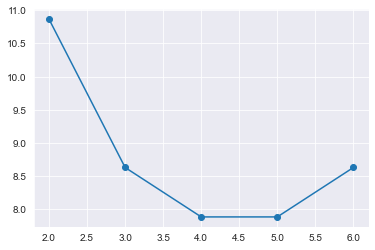

In [19]:
# 2) k-NN and evaluation
from sklearn import neighbors

# Loop on several models ! and check for which value of the hyperparameter k we get the least error percentage.
errors = []
k_start, k_end = 2, 7
for k in range(k_start, k_end):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    # We "fit" the model to our training data and compute the percentage of correct predictions with "score"
    errors.append(100*(1 - knn.fit(X_train, y_train).score(X_test, y_test)))
plt.plot(range(k_start, k_end), errors, 'o-')
plt.show()

In [20]:
# 3) predict !!
# We use the best classifier to predict
k = 3
knn = neighbors.KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

X_pred = zipcode_na_df[["Latitude", "Longitude", "CouncilDistrictCode"]] # 16 missing postal code
correct_target = np.array(correct_zipcode, dtype=np.float64) # 16 correct ZipCodes / dtype so that it won't be int32

y_pred = knn.predict(X_pred)
print(y_pred)
print(correct_target)

# Accuracy of what X_pred predicted (y_pred) and correct_targer
knn.score(X_pred, correct_target)
# Accuracy 14/16 = 0.875, means two wrong predictions.
# Accuracy 15/16 = 0.9375, means one wrong prediction. ;) with CouncilDistrict we get better results ;)

error = 1 - knn.score(X_pred, correct_target)
print('Error in prediction : %.3f' % error) # .1 means 1 decimal, .2 means 2 decimals
print('Error in prediction : {:.1%}'.format(error))

[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98144. 98104. 98109. 98108. 98108.]
[98125. 98144. 98117. 98125. 98107. 98117. 98119. 98112. 98122. 98118.
 98126. 98108. 98104. 98119. 98108. 98108.]
Error in prediction : 0.125
Error in prediction : 12.5%


In [21]:
print("We replace the missing ZipCodes by their correct value.")

#zipcode_na_df.index
# We iterate on the index of the buildings for which the ZipCode is missing
all_data_v1 = all_data.copy()
for i, index in enumerate(zipcode_na_df.index):
    all_data_v1.at[index, "ZipCode"] = correct_zipcode[i]

# Verification
#all_data_v1["ZipCode"].shape
display(all_data_v1[all_data_v1["ZipCode"].isna()])


We replace the missing ZipCodes by their correct value.


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity


### 3) Dropping features

We have 46 columns / features to represent each building.

We select the interesting features that will help us predict the energy consumption of the buildings.

We keep for now **ComplianceStatus** and **Outlier** so that we can remove outlier buildings.

In [22]:
columns_to_drop = ["DataYear", "PropertyName", "ListOfAllPropertyUseTypes", "Address", "City", "State", "TaxParcelIdentificationNumber", "YearsENERGYSTARCertified", "DefaultData", "Comments", "Latitude", "Longitude"]

print("We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.")

We remove latitude and longitude so that our algorithm won't have too much features. We will localize the buildings based on the Zip Code and the Council District Code.


In [23]:
all_data_v1 = drop_selected_features(all_data_v1, columns_to_drop)
display(all_data_v1)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.00,7,downtown,1927,1.00,12,88434,0,88434,Hotel,88434.00,NaN,NaN,NaN,NaN,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,98101.00,7,downtown,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,98101.00,7,downtown,1969,1.00,41,956110,196718,759392,Hotel,756493.00,NaN,NaN,NaN,NaN,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,98101.00,7,downtown,1926,1.00,10,61320,0,61320,Hotel,61320.00,NaN,NaN,NaN,NaN,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,98121.00,7,downtown,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,98108.00,2,greater duwamish,1990,1.00,1,12294,0,12294,Office,12294.00,NaN,NaN,NaN,NaN,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,Nonresidential COS,Other,98104.00,2,downtown,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,NaN,NaN,NaN,NaN,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,Compliant,NaN,32.17,2.01
3373,50224,Nonresidential COS,Other,98119.00,7,magnolia / queen anne,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,Compliant,NaN,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,98108.00,1,greater duwamish,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,Compliant,NaN,22.11,1.57


### 4) Verifying GFA

In [24]:
# df = all_data[["PropertyGFATotal", "PropertyGFABuilding(s)", "PropertyGFAParking"]]
# df.describe()

verify_PropertyGFA(all_data_v1)

End of checking.


We have checked that the Total Property GFA is equal to the Total Building(s) GFA + Total Parking GFA.

### 5) Verifying Property Use Type

We display the proportion of NaN per feature for our dataset.

**Analysis** :
- We notice with the barplot below that the Second and Third Largest Property (GFA and Type) have more than 50% of missing values.

- Outliers too is a feature with more than 90% of missing values : that's because if the value is missing it means the building is not an outlier.

In [25]:
# We use head(10) to only display 10 features that have the most missing values.
data_nan = all_data_v1.isna().sum().sort_values(ascending=False).head(10)

#data_nan

In [26]:
data_nan.values
all_data_v1.shape

(3376, 34)

<AxesSubplot:title={'center':'Proportion of NaN per feature (%)'}>

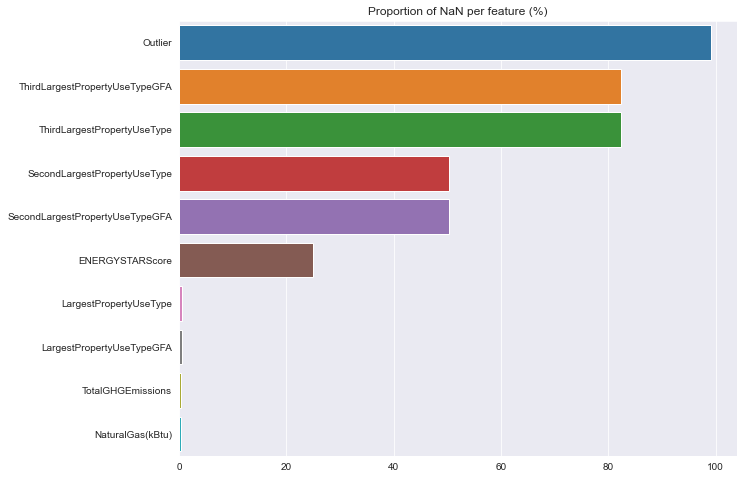

In [27]:
plt.figure(figsize=(10,8))
plt.title('Proportion of NaN per feature (%)')
sns.barplot(x= 100 * data_nan.values / all_data_v1.shape[0], y=data_nan.index)

In [28]:
all_data_v2 = fill_property_use_type_GFA(all_data_v1)

display(all_data_v2)

This won't work if you set the category before this function.


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,NonResidential,Hotel,98101.00,7,downtown,1927,1.00,12,88434,0,88434,Hotel,88434.00,None,0.00,None,0.00,60.00,81.70,84.30,182.50,189.00,7226362.50,7456910.00,2003882.00,1156514.25,3946027.00,12764.53,1276453.00,Compliant,NaN,249.98,2.83
1,2,NonResidential,Hotel,98101.00,7,downtown,1996,1.00,11,103566,15064,88502,Hotel,83880.00,Parking,15064.00,Restaurant,4622.00,61.00,94.80,97.90,176.10,179.40,8387933.00,8664479.00,0.00,950425.19,3242851.00,51450.82,5145082.00,Compliant,NaN,295.86,2.86
2,3,NonResidential,Hotel,98101.00,7,downtown,1969,1.00,41,956110,196718,759392,Hotel,756493.00,None,0.00,None,0.00,43.00,96.00,97.70,241.90,244.10,72587024.00,73937112.00,21566554.00,14515435.00,49526664.00,14938.00,1493800.00,Compliant,NaN,2089.28,2.19
3,5,NonResidential,Hotel,98101.00,7,downtown,1926,1.00,10,61320,0,61320,Hotel,61320.00,None,0.00,None,0.00,56.00,110.80,113.30,216.20,224.00,6794584.00,6946800.50,2214446.25,811525.31,2768924.00,18112.13,1811213.00,Compliant,NaN,286.43,4.67
4,8,NonResidential,Hotel,98121.00,7,downtown,1980,1.00,18,175580,62000,113580,Hotel,123445.00,Parking,68009.00,Swimming Pool,0.00,75.00,114.80,118.70,211.40,215.60,14172606.00,14656503.00,0.00,1573448.62,5368607.00,88039.98,8803998.00,Compliant,NaN,505.01,2.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,50222,Nonresidential COS,Office,98108.00,2,greater duwamish,1990,1.00,1,12294,0,12294,Office,12294.00,None,0.00,None,0.00,46.00,69.10,76.70,161.70,176.10,849745.69,943003.19,0.00,153655.00,524270.86,3254.75,325475.02,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,Nonresidential COS,Other,98104.00,2,downtown,2004,1.00,1,16000,0,16000,Other - Recreation,16000.00,None,0.00,None,0.00,NaN,59.40,65.90,114.20,118.90,950276.19,1053705.75,0.00,116221.00,396546.05,5537.30,553729.98,Compliant,NaN,32.17,2.01
3373,50224,Nonresidential COS,Other,98119.00,7,magnolia / queen anne,1974,1.00,1,13157,0,13157,Other - Recreation,7583.00,Fitness Center/Health Club/Gym,5574.00,Swimming Pool,0.00,NaN,438.20,460.10,744.80,767.80,5765898.00,6053764.50,0.00,525251.69,1792158.76,39737.39,3973739.06,Compliant,NaN,223.54,16.99
3374,50225,Nonresidential COS,Mixed Use Property,98108.00,1,greater duwamish,1989,1.00,1,14101,0,14101,Other - Recreation,6601.00,Fitness Center/Health Club/Gym,6501.00,Pre-school/Daycare,484.00,NaN,51.00,55.50,105.30,110.80,719471.19,782841.31,0.00,102248.00,348870.18,3706.01,370601.00,Compliant,NaN,22.11,1.57


We have filled Second and Third Property Use Type GFA by 0 (meaning there are no second or  third use for the building.
We have also filled the Second and Third Property USe Type by "None".

#### Change variable's type

In [29]:
columns_to_categorize = ["OSEBuildingID", "BuildingType", "PrimaryPropertyType", "Neighborhood", "ZipCode", "CouncilDistrictCode", "YearBuilt", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]

all_data_v2 = assign_type_column(all_data_v2, columns_to_categorize, "category")

print("We have changed the type of the categorical features to 'category'.")
display(all_data_v2.dtypes)

We have changed the type of the categorical features to 'category'.


OSEBuildingID                      category
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
Neighborhood                       category
YearBuilt                          category
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEUI(kBtu/sf)                    float64
SiteEUIWN(kBtu/sf)                  float64
SourceEUI(kBtu/sf)                  float64
SourceEUIWN(kBtu/sf)            

### 6) Outliers cleaning

#### 6.1) 0utliers described in the dataset

Outlier : Whether a property is a high or low outlier

In [30]:
print("Checking Outliers.")

# We have a column called "Outlier" in which we have 32 buildings which are considered outliers.
outliers_examples = all_data_v2[~all_data_v2["Outlier"].isna()] # 32 outliers in raw dataset and in all_data_v2

display(outliers_examples)

Checking Outliers.


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
226,350,NonResidential,Large Office,98101.00,7,downtown,1958,1.00,6,172842,25920,146922,Office,99890.00,Data Center,39336.00,Parking,25000.00,NaN,297.40,299.20,909.60,911.50,41399504.00,41650404.00,0.00,11663150.00,39794668.00,16048.31,1604831.00,Non-Compliant,High outlier,362.66,2.10
384,539,NonResidential,Retail Store,98105.00,4,northeast,1987,1.00,2,69492,0,69492,Retail Store,69800.00,Other,0.00,None,0.00,100.00,4.60,4.60,14.30,14.30,318962.81,318962.81,0.00,93482.60,318963.00,0.00,0.00,Non-Compliant,Low outlier,2.22,0.03
448,608,NonResidential,Large Office,98104.00,2,downtown,1913,5.00,7,154159,0,154159,Office,193154.00,None,0.00,None,0.00,100.00,58.00,58.80,28.00,28.70,11195917.00,11348758.00,0.00,471503.00,1608768.00,3430.50,343050.00,Non-Compliant,Low outlier,29.43,0.19
517,704,NonResidential,Large Office,98119.00,7,magnolia / queen anne,2000,1.00,4,129551,42500,87051,Office,82273.00,Parking,42500.00,Data Center,4778.00,1.00,311.70,311.70,978.90,978.90,27137190.00,27137190.00,0.00,7953454.50,27137187.00,0.00,0.00,Non-Compliant,High outlier,189.18,1.46
720,19708,Multifamily HR (10+),High-Rise Multifamily,98121.00,7,downtown,1982,1.00,24,167941,0,167941,Multifamily Housing,138787.00,Parking,99952.00,Swimming Pool,0.00,100.00,17.30,18.70,50.40,54.00,2407904.50,2589125.50,0.00,626561.62,2137828.00,2700.76,270076.00,Non-Compliant,Low outlier,29.25,0.17
834,19934,Multifamily LR (1-4),Low-Rise Multifamily,98102.00,3,east,1989,1.00,4,31702,0,31702,Multifamily Housing,26418.00,Parking,14280.00,None,0.00,NaN,9.70,10.40,30.40,32.70,255971.20,275412.00,0.00,75020.90,255971.00,0.00,0.00,Non-Compliant,Low outlier,1.78,0.06
839,19967,SPS-District K-12,K-12 School,98109.00,7,magnolia / queen anne,2001,1.00,1,35805,0,35805,K-12 School,35805.00,None,0.00,None,0.00,100.00,12.10,12.10,27.00,27.00,431471.69,431471.69,0.00,72282.40,246628.00,1848.44,184844.00,Error - Correct Default Data,Low outlier,11.54,0.32
962,20367,Multifamily LR (1-4),Low-Rise Multifamily,98126.00,1,southwest,1990,1.00,3,70207,0,70207,Multifamily Housing,71273.00,None,0.00,None,0.00,100.00,9.90,9.90,30.90,30.90,702481.38,702481.38,0.00,205885.50,702481.00,0.00,0.00,Non-Compliant,Low outlier,4.90,0.07
1045,20617,NonResidential,Retail Store,98134.00,2,greater duwamish,1953,1.00,1,39900,0,39900,Retail Store,25000.00,Non-Refrigerated Warehouse,15000.00,None,0.00,100.00,3.60,3.60,6.40,6.40,145468.80,145468.80,0.00,14362.50,49005.00,964.64,96464.00,Error - Correct Default Data,Low outlier,5.46,0.14
1229,21315,NonResidential,Small- and Mid-Sized Office,98101.00,7,downtown,1903,1.00,3,57720,0,57720,Office,25000.00,None,0.00,None,0.00,NaN,1.00,1.00,3.00,3.00,24105.50,24105.50,0.00,7064.90,24105.00,0.00,0.00,Non-Compliant,Low outlier,0.17,0.00


#### 6.2) Compliance Status described in the dataset


This is an histogram that presents the distribution of the values of the variable ComplianceStatus in %.


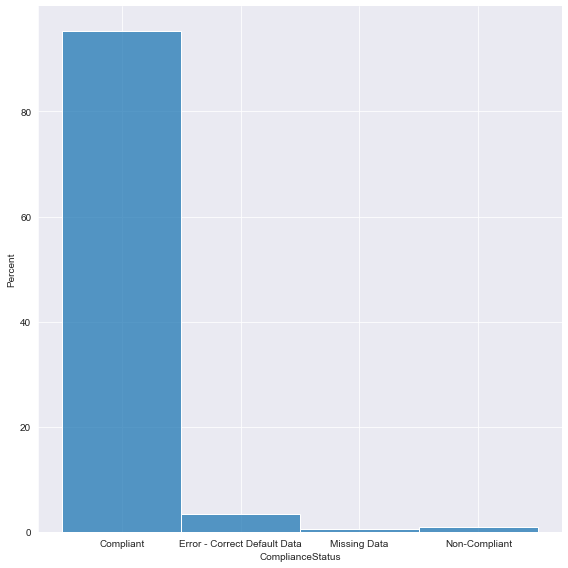

In [31]:
print("This is an histogram that presents the distribution of the values of the variable ComplianceStatus in %.")
sns.displot(data=all_data_v2, x="ComplianceStatus", stat='percent', height=8, aspect=1) # aspect : to make it wider

This is an histogram that presents the distribution of the values of the variable ComplianceStatus by counting them.


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='ComplianceStatus', ylabel='count'>

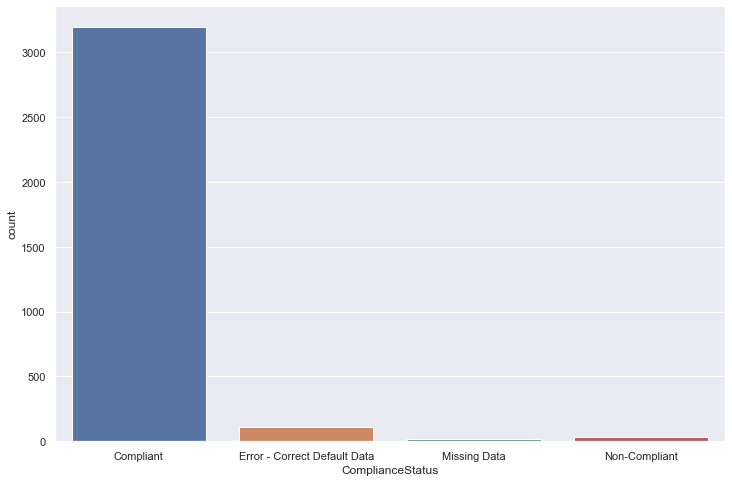

In [32]:
print("This is an histogram that presents the distribution of the values of the variable ComplianceStatus by counting them.")
# to make the graphs bigger
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(data=all_data_v2, x="ComplianceStatus") # countnplot is for discrete variable / categories here.

In [33]:
print("Checking ComplianceStatus.")
display(all_data_v2["ComplianceStatus"].unique())

non_compliant_status = ['Error - Correct Default Data', 'Missing Data', 'Non-Compliant']

non_compliant_buildings = all_data_v2[all_data_v2["ComplianceStatus"].isin(non_compliant_status)]
display(non_compliant_buildings)

print("In the raw dataset, we had :", all_data[all_data["ComplianceStatus"].isin(non_compliant_status)].shape[0], "non compliant buildings.")

Checking ComplianceStatus.


array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
22,28,SPS-District K-12,K-12 School,98118.00,2,southeast,1961,1.00,2,56228,0,56228,K-12 School,58916.00,None,0.00,None,0.00,95.00,26.10,29.10,60.70,64.60,1539478.50,1713623.50,0.00,274605.91,936955.00,6025.23,602523.00,Error - Correct Default Data,NaN,38.53,0.69
28,34,SPS-District K-12,K-12 School,98112.00,3,central,1955,1.00,1,126351,0,126351,K-12 School,126351.00,None,0.00,None,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Missing Data,NaN,0.00,0.00
30,36,SPS-District K-12,K-12 School,98125.00,5,north,1949,1.00,2,160645,0,160645,K-12 School,164229.00,None,0.00,None,0.00,75.00,41.30,47.50,68.10,75.70,6779173.00,7800349.50,0.00,570809.19,1947601.00,48315.72,4831572.00,Error - Correct Default Data,NaN,270.18,1.68
31,37,SPS-District K-12,K-12 School,98109.00,7,magnolia / queen anne,1989,1.00,2,51582,0,51582,K-12 School,55166.00,None,0.00,None,0.00,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,438691.69,1496816.00,0.00,0.00,Missing Data,NaN,10.43,0.20
38,51,SPS-District K-12,K-12 School,98115.00,4,northeast,1950,1.00,2,175565,0,175565,K-12 School,182861.00,None,0.00,None,0.00,88.00,35.00,40.10,55.00,60.40,6399127.50,7329817.50,0.00,468840.50,1599684.00,47994.43,4799443.00,Error - Correct Default Data,NaN,266.05,1.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3265,49943,Multifamily LR (1-4),Low-Rise Multifamily,98101.00,7,downtown,1904,1.00,3,49000,0,49000,Multifamily Housing,21600.00,Food Sales,5663.00,Retail Store,4027.00,NaN,136.70,139.30,366.80,372.40,4602793.50,4691944.50,0.00,1054888.88,3599281.00,10035.12,1003512.00,Non-Compliant,High outlier,78.39,1.60
3341,50071,Multifamily MR (5-9),Mid-Rise Multifamily,98102.00,3,east,2015,1.00,7,41384,15062,26322,Multifamily Housing,34643.00,Parking,8266.00,"Personal Services (Health/Beauty, Dry Cleaning...",1714.00,100.00,0.40,0.40,1.10,1.10,13409.00,13409.00,0.00,3930.00,13409.00,0.00,0.00,Non-Compliant,Low outlier,0.09,0.00
3366,50210,Nonresidential COS,Office,98119.00,7,magnolia / queen anne,1952,1.00,1,13661,0,13661,Office,13661.00,None,0.00,None,0.00,75.00,36.80,40.90,115.50,128.40,502667.69,558525.12,0.00,147323.50,502667.78,0.00,0.00,Error - Correct Default Data,NaN,3.50,0.26
3369,50220,Nonresidential COS,Office,98118.00,2,southeast,1960,1.00,1,15398,0,15398,Office,15398.00,None,0.00,None,0.00,93.00,25.20,26.90,64.10,66.70,387810.00,414172.41,0.00,81341.40,277536.85,1102.73,110273.00,Error - Correct Default Data,NaN,7.79,0.51


In the raw dataset, we had : 165 non compliant buildings.


In [34]:
all_data_v3 = drop_outliers_based_on_dataset(all_data_v2)

Before removing the non compliant buildings : (3356, 34)
After removing the non compliant buildings : (3196, 34)
Before removing the 32 outliers : (3196, 34)
After removing the outliers : (3196, 34)
We delete the columns ComplianceStatus and Outlier.


In [35]:
print("We have removed 60 buildings which were not compliant. And amongst these 60 buildings, 32 were outliers.")

We have removed 60 buildings which were not compliant. And amongst these 60 buildings, 32 were outliers.


#### 6.3) Cleaning NaN values

##### 6.3.1) Removing buildings with NaN values

In [36]:
columns_with_nan = all_data_v3.columns[all_data_v3.isna().any()].tolist()
print("These columns have empty values (NaN) :", columns_with_nan, end='\n\n')
print("For the Energy Star Score, we will keep it untouched until later.", end='\n\n')

x = all_data_v3[all_data_v3["SiteEUIWN(kBtu/sf)"].isna()]
display(x)

y = all_data_v3[all_data_v3["SiteEnergyUseWN(kBtu)"].isna()]
display(y)

These columns have empty values (NaN) : ['ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)']

For the Energy Star Score, we will keep it untouched until later.



,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
563,757,NonResidential,Large Office,98121.00,7,downtown,1979,1.00,7,131143,87160,43983,Office,120248.00,Retail Store,10853.00,None,0.00,93.00,39.50,NaN,128.00,0.00,5177270.50,NaN,0.00,1427645.25,4871126.00,14160.41,1416041.00,109.16,0.83


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
563,757,NonResidential,Large Office,98121.00,7,downtown,1979,1.00,7,131143,87160,43983,Office,120248.00,Retail Store,10853.00,None,0.00,93.00,39.50,NaN,128.00,0.00,5177270.50,NaN,0.00,1427645.25,4871126.00,14160.41,1416041.00,109.16,0.83


In [37]:
print("We remove 1 building with SiteEUI(kBtu/sf) and SiteEnergyUseWN(kBtu) as NaN.")

features_with_nan = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)"]
all_data_v4 = drop_buildings_subset_nan(all_data_v3, features_with_nan)

We remove 1 building with SiteEUI(kBtu/sf) and SiteEnergyUseWN(kBtu) as NaN.


##### 6.3.2) Cleaning Energy Star Score

In [38]:
print("ENERGYSTARScore and its NaN :")

print("For the", all_data_v4[all_data_v4["ENERGYSTARScore"].isna()].shape[0], "buildings that do not have an Energy Star Score, we fill it with -1 for now.")
#all_data_v4[all_data_v4["ENERGYSTARScore"].isna()].count

all_data_v4 = fill_nan_column_by_value(all_data_v4, "ENERGYSTARScore", -1)

ENERGYSTARScore and its NaN :
For the 804 buildings that do not have an Energy Star Score, we fill it with -1 for now.


#### 6.4) Energy or GHG Outliers (negative values)

In [39]:
display(all_data_v4.describe())
print(all_data_v4.shape)


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00,3195.00
mean,1.14,4.80,95970.22,8375.03,87595.19,79439.12,14552.00,2165.15,50.11,55.71,58.03,136.67,140.22,5548417.82,5404201.28,286430.44,1115524.22,3806168.65,13889.43,1388943.24,122.41,1.19
std,2.16,5.60,223304.16,33139.02,212048.36,205605.41,40108.12,13450.61,37.71,56.84,57.73,139.99,139.73,22163695.04,16323752.47,4012833.37,4458427.38,15212154.21,68783.21,6878320.61,552.52,1.85
min,1.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,-1.00,1.40,0.00,0.00,-2.10,57133.20,0.00,0.00,-33826.80,-115417.00,0.00,0.00,-0.80,-0.02
25%,1.00,2.00,28284.00,0.00,27552.00,24989.00,0.00,0.00,-1.00,28.10,29.50,75.50,79.20,940129.16,988072.09,0.00,188439.70,642956.00,0.00,0.00,9.65,0.21
50%,1.00,4.00,43832.00,0.00,42848.00,39000.00,0.00,0.00,60.00,39.30,41.50,97.70,102.90,1809586.75,1908057.88,0.00,347841.41,1186835.00,3214.97,321497.00,34.00,0.62
75%,1.00,5.00,91580.00,0.00,84744.50,76627.50,11400.00,0.00,85.00,61.50,65.55,146.65,151.15,4277746.75,4435780.50,0.00,845344.47,2884315.00,11830.18,1183018.00,94.38,1.38
max,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,639931.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,16870.98,34.09


(3195, 32)


In [40]:
print("We can see that we have negative values for theses features : ")

all_energy_features = ["SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)", "SteamUse(kBtu)", "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)", "TotalGHGEmissions", "GHGEmissionsIntensity"]

features_with_negative_values = verify_min_value(all_data_v4, all_energy_features, 0)

print("This is the list of features for which we will remove outliers :", features_with_negative_values)

We can see that we have negative values for theses features : 
For this feature : SourceEUIWN(kBtu/sf) we have this negative value : -2.099999905
For this feature : Electricity(kWh) we have this negative value : -33826.80078
For this feature : Electricity(kBtu) we have this negative value : -115417.0
For this feature : TotalGHGEmissions we have this negative value : -0.8
For this feature : GHGEmissionsIntensity we have this negative value : -0.02
This is the list of features for which we will remove outliers : ['SourceEUIWN(kBtu/sf)', 'Electricity(kWh)', 'Electricity(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


In [41]:
all_data_v5 = removing_outliers(all_data_v4, "SourceEUIWN(kBtu/sf)", 0, less_than_or_equal=False)
print("We had one outlier building for which the energy values were negative.")

display(all_data_v5.describe())
print(all_data_v5.shape)

We had one outlier building for which the energy values were negative.


,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00,3194.00
mean,1.14,4.80,95983.99,8377.65,87606.33,79448.91,14556.56,2165.83,50.09,55.73,58.05,136.71,140.27,5550047.66,5405818.09,286520.12,1115884.07,3807396.44,13893.78,1389378.10,122.45,1.19
std,2.16,5.60,223337.77,33143.88,212080.63,205636.86,40113.57,13452.67,37.70,56.84,57.73,140.00,139.73,22166973.95,16326052.59,4013458.50,4459079.08,15214377.80,68793.54,6879353.69,552.60,1.85
min,1.00,0.00,11285.00,0.00,3636.00,5656.00,0.00,0.00,-1.00,1.40,0.00,0.00,0.00,57133.20,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,2.00,28280.50,0.00,27551.50,24988.50,0.00,0.00,-1.00,28.10,29.50,75.52,79.20,940947.84,988526.84,0.00,188527.90,643257.00,0.00,0.00,9.65,0.21
50%,1.00,4.00,43813.00,0.00,42832.00,38996.50,0.00,0.00,60.00,39.30,41.50,97.70,102.90,1810546.56,1910731.06,0.00,347868.66,1186928.00,3214.99,321498.50,34.00,0.62
75%,1.00,5.00,91590.00,0.00,84747.25,76629.25,11400.00,0.00,85.00,61.50,65.57,146.67,151.17,4282593.12,4437788.00,0.00,845612.05,2885228.00,11830.62,1183062.00,94.43,1.38
max,111.00,99.00,9320156.00,512608.00,9320156.00,9320156.00,639931.00,459748.00,100.00,834.40,834.40,2620.00,2620.00,873923712.00,471613856.00,134943456.00,192577488.00,657074389.00,2979090.00,297909000.00,16870.98,34.09


(3194, 32)


In [42]:
print("We run the same program to check if we still have negative values for the energy.")
verify_min_value(all_data_v5, all_energy_features, 0)

We run the same program to check if we still have negative values for the energy.


[]

### 7) Verification Total Energy

We consider that the **Total Energy** of a building is represented by the variable **SiteEnergyUse(kBtu)**.
Thus  **SiteEnergyUse(kBtu)** = **Electricity(kBtu)** + **SteamUse(kBtu)** + **NaturalGas(kBtu)** + **OtherEnergy(kBtu)**

We will compute the difference between the Total Energy and Electricity(kBtu) + SteamUse(kBtu) + NaturalGas(kBtu) and if the difference / error / other energy is greater than 1% we drop the building.

In [43]:
print("The computed remaining energy is the absolute value of the percentage of total energy that remaining energy has.")
print("The computation of the remaining energy is based on a hypothesis that the site energy is the sum of electricity, steam and natural gas.")
all_data_v6 = compute_TotalEnergy(all_data_v5).sort_values(by="RemainingEnergy(%)", ascending=False)
display(all_data_v6)

The computed remaining energy is the absolute value of the percentage of total energy that remaining energy has.
The computation of the remaining energy is based on a hypothesis that the site energy is the sum of electricity, steam and natural gas.


,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)
513,700,NonResidential,Supermarket / Grocery Store,98119.00,7,magnolia / queen anne,2008,1.00,1,57176,0,57176,Supermarket/Grocery Store,39500.00,Retail Store,15000.00,"Personal Services (Health/Beauty, Dry Cleaning...",5500.00,31.00,208.80,214.10,0.00,0.00,12525174.00,12843856.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12525174.00,100.00
1323,21524,Multifamily LR (1-4),Low-Rise Multifamily,98102.00,4,lake union,1974,1.00,4,37361,4735,32626,Multifamily Housing,27732.00,None,0.00,None,0.00,61.00,31.70,33.20,0.00,0.00,880115.50,919767.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,880115.50,100.00
2761,26849,NonResidential,Retail Store,98104.00,2,downtown,1917,1.00,2,24550,0,24550,Retail Store,13500.00,Office,11050.00,None,0.00,100.00,39.80,42.00,16.40,17.70,977230.31,1031447.62,0.00,26436.40,90201.00,1147.94,114794.00,6.73,0.27,772235.31,79.00
2257,25004,Multifamily LR (1-4),Low-Rise Multifamily,98112.00,3,central,1926,1.00,3,27840,7031,20809,Multifamily Housing,20809.00,Parking,7031.00,None,0.00,17.00,108.30,108.90,142.70,143.70,2253647.75,2266028.75,0.00,93702.70,319714.00,2922.53,292253.00,17.75,0.64,1641680.75,72.80
2791,26973,NonResidential,Mixed Use Property,98104.00,2,downtown,1909,1.00,3,49299,0,49299,Office,24099.00,Multifamily Housing,23632.00,Restaurant,5320.00,-1.00,89.20,90.90,0.00,0.00,4729846.50,4821852.00,0.00,387981.31,1323792.00,0.00,0.00,9.23,0.19,3406054.50,72.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,21122,NonResidential,Mixed Use Property,98103.00,6,lake union,2001,5.00,3,41827,9226,32601,Multifamily Housing,14273.00,Office,14128.00,Parking,9680.00,-1.00,100.30,102.50,227.10,229.50,4193371.00,4288601.50,0.00,714858.00,2439095.00,17542.75,1754275.00,110.17,2.63,1.00,0.00
1160,21124,Multifamily LR (1-4),Low-Rise Multifamily,98103.00,6,lake union,1907,1.00,4,36660,0,36660,Multifamily Housing,36660.00,None,0.00,None,0.00,98.00,25.40,26.70,56.20,59.60,930368.50,979751.19,0.00,151705.59,517619.00,4127.49,412749.00,25.53,0.70,0.50,0.00
1161,21125,NonResidential,Small- and Mid-Sized Office,98103.00,6,lake union,2001,1.00,5,33740,6010,27730,Office,15908.00,Retail Store,8762.00,Parking,1500.00,79.00,52.30,52.30,164.40,164.40,1291405.25,1291405.25,0.00,378489.19,1291405.00,0.00,0.00,9.00,0.27,0.25,0.00
1162,21129,NonResidential,Retail Store,98103.00,6,lake union,1911,1.00,2,20516,0,20516,Retail Store,10155.00,Hotel,8000.00,None,0.00,98.00,56.30,61.10,89.60,93.30,1021796.62,1109483.12,0.00,77662.50,264984.00,7568.12,756812.00,42.04,2.05,0.62,0.00


In [44]:
all_data_v7 = removing_outliers(all_data_v6, "RemainingEnergy(%)", 0.01, less_than_or_equal=True)
display(all_data_v7)

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)
2258,25006,Multifamily LR (1-4),Low-Rise Multifamily,98112.00,3,central,1978,1.00,3,20739,0,20739,Multifamily Housing,17628.00,None,0.00,None,0.00,19.00,46.30,49.30,145.40,154.80,816300.50,869296.31,0.00,239244.00,816301.00,0.00,0.00,5.69,0.27,-0.50,0.00
2259,25025,NonResidential,Warehouse,98144.00,3,greater duwamish,1928,1.00,2,25955,0,25955,Non-Refrigerated Warehouse,14150.00,Other - Services,8745.00,Office,3060.00,-1.00,46.90,46.90,147.40,147.40,1218112.00,1218112.00,0.00,357008.19,1218112.00,0.00,0.00,8.49,0.33,0.00,0.00
2260,25028,Multifamily LR (1-4),Low-Rise Multifamily,98144.00,2,greater duwamish,1925,1.00,3,25120,0,25120,Multifamily Housing,25120.00,None,0.00,None,0.00,98.00,23.30,24.50,49.80,52.70,586358.88,615255.38,0.00,89109.90,304043.00,2823.16,282316.00,17.11,0.68,-0.12,0.00
2261,25046,Multifamily HR (10+),High-Rise Multifamily,98144.00,2,greater duwamish,1971,1.00,15,73898,0,73898,Multifamily Housing,79912.00,None,0.00,None,0.00,75.00,40.30,42.80,98.70,105.50,3221754.00,3419861.50,0.00,631404.31,2154352.00,10674.02,1067402.00,71.71,0.97,0.00,0.00
2262,25047,Multifamily LR (1-4),Low-Rise Multifamily,98108.00,2,greater duwamish,2001,1.00,3,36383,7030,29353,Multifamily Housing,25153.00,Office,4200.00,Parking,0.00,-1.00,32.70,34.70,81.20,84.10,960987.81,1019654.31,0.00,192884.09,658121.00,3028.67,302867.00,20.67,0.57,-0.19,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,21122,NonResidential,Mixed Use Property,98103.00,6,lake union,2001,5.00,3,41827,9226,32601,Multifamily Housing,14273.00,Office,14128.00,Parking,9680.00,-1.00,100.30,102.50,227.10,229.50,4193371.00,4288601.50,0.00,714858.00,2439095.00,17542.75,1754275.00,110.17,2.63,1.00,0.00
1160,21124,Multifamily LR (1-4),Low-Rise Multifamily,98103.00,6,lake union,1907,1.00,4,36660,0,36660,Multifamily Housing,36660.00,None,0.00,None,0.00,98.00,25.40,26.70,56.20,59.60,930368.50,979751.19,0.00,151705.59,517619.00,4127.49,412749.00,25.53,0.70,0.50,0.00
1161,21125,NonResidential,Small- and Mid-Sized Office,98103.00,6,lake union,2001,1.00,5,33740,6010,27730,Office,15908.00,Retail Store,8762.00,Parking,1500.00,79.00,52.30,52.30,164.40,164.40,1291405.25,1291405.25,0.00,378489.19,1291405.00,0.00,0.00,9.00,0.27,0.25,0.00
1162,21129,NonResidential,Retail Store,98103.00,6,lake union,1911,1.00,2,20516,0,20516,Retail Store,10155.00,Hotel,8000.00,None,0.00,98.00,56.30,61.10,89.60,93.30,1021796.62,1109483.12,0.00,77662.50,264984.00,7568.12,756812.00,42.04,2.05,0.62,0.00


In [45]:
total_energy_outliers = all_data_v6[all_data_v6["RemainingEnergy(%)"] > 0.01]
display(total_energy_outliers)

print("By removing these :", total_energy_outliers.shape[0], "outlier buildings, we lose :", round(100 * total_energy_outliers.shape[0] / all_data_v6.shape[0], 2), "% of our buildings.")

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity,RemainingEnergy(kBtu),RemainingEnergy(%)
513,700,NonResidential,Supermarket / Grocery Store,98119.00,7,magnolia / queen anne,2008,1.00,1,57176,0,57176,Supermarket/Grocery Store,39500.00,Retail Store,15000.00,"Personal Services (Health/Beauty, Dry Cleaning...",5500.00,31.00,208.80,214.10,0.00,0.00,12525174.00,12843856.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,12525174.00,100.00
1323,21524,Multifamily LR (1-4),Low-Rise Multifamily,98102.00,4,lake union,1974,1.00,4,37361,4735,32626,Multifamily Housing,27732.00,None,0.00,None,0.00,61.00,31.70,33.20,0.00,0.00,880115.50,919767.69,0.00,0.00,0.00,0.00,0.00,0.00,0.00,880115.50,100.00
2761,26849,NonResidential,Retail Store,98104.00,2,downtown,1917,1.00,2,24550,0,24550,Retail Store,13500.00,Office,11050.00,None,0.00,100.00,39.80,42.00,16.40,17.70,977230.31,1031447.62,0.00,26436.40,90201.00,1147.94,114794.00,6.73,0.27,772235.31,79.00
2257,25004,Multifamily LR (1-4),Low-Rise Multifamily,98112.00,3,central,1926,1.00,3,27840,7031,20809,Multifamily Housing,20809.00,Parking,7031.00,None,0.00,17.00,108.30,108.90,142.70,143.70,2253647.75,2266028.75,0.00,93702.70,319714.00,2922.53,292253.00,17.75,0.64,1641680.75,72.80
2791,26973,NonResidential,Mixed Use Property,98104.00,2,downtown,1909,1.00,3,49299,0,49299,Office,24099.00,Multifamily Housing,23632.00,Restaurant,5320.00,-1.00,89.20,90.90,0.00,0.00,4729846.50,4821852.00,0.00,387981.31,1323792.00,0.00,0.00,9.23,0.19,3406054.50,72.00
505,688,Multifamily MR (5-9),Mid-Rise Multifamily,98104.00,2,downtown,2002,1.00,5,228288,32295,195993,Multifamily Housing,80298.00,Parking,29050.00,Other - Entertainment/Public Assembly,16116.00,-1.00,55.60,58.50,0.00,0.00,5974993.50,6284895.50,0.00,576479.31,1966947.00,0.00,0.00,13.71,0.06,4008046.50,67.10
3350,50086,Multifamily LR (1-4),Low-Rise Multifamily,98119.00,7,magnolia / queen anne,2015,1.00,4,51095,2784,48311,Multifamily Housing,49324.00,Parking,2791.00,None,0.00,1.00,55.80,60.70,288.10,315.90,2751301.25,2992911.00,0.00,1326488.25,4525978.00,0.00,0.00,31.55,0.62,-1774676.75,64.50
675,19536,Multifamily LR (1-4),Low-Rise Multifamily,98116.00,1,southwest,1976,1.00,4,38765,0,38765,Multifamily Housing,38765.00,None,0.00,None,0.00,92.00,41.40,44.00,63.70,67.40,1339220.62,1424044.50,0.00,192448.30,656634.00,0.00,0.00,4.58,0.12,682586.62,51.00
601,803,NonResidential,Small- and Mid-Sized Office,98106.00,1,delridge,1929,1.00,3,85126,0,85126,Office,81526.00,None,0.00,None,0.00,1.00,465.50,467.00,725.60,727.20,37951708.00,38074932.00,0.00,5454295.00,18610055.00,6851.32,685132.00,166.13,1.95,18656521.00,49.20
3277,49972,NonResidential,University,98195.00,4,northeast,1998,1.00,6,203030,0,203030,College/University,203030.00,None,0.00,None,0.00,-1.00,252.00,0.00,561.00,0.00,51168308.00,0.00,0.00,8386463.50,28614613.00,0.00,0.00,199.48,0.98,22553695.00,44.10


By removing these : 37 outlier buildings, we lose : 1.16 % of our buildings.


In [46]:
print("We remove the two columns about the remaining energy")
all_data_v8 = all_data_v7.drop(columns=["RemainingEnergy(kBtu)", "RemainingEnergy(%)"])
all_data_v8.shape

We remove the two columns about the remaining energy
ASK MENTOR


### 8) Final step

#### 8.1) Boxplot and Outliers

After removing outliers, we display boxplot per energy feature and per Primary Property Type.
We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.


C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


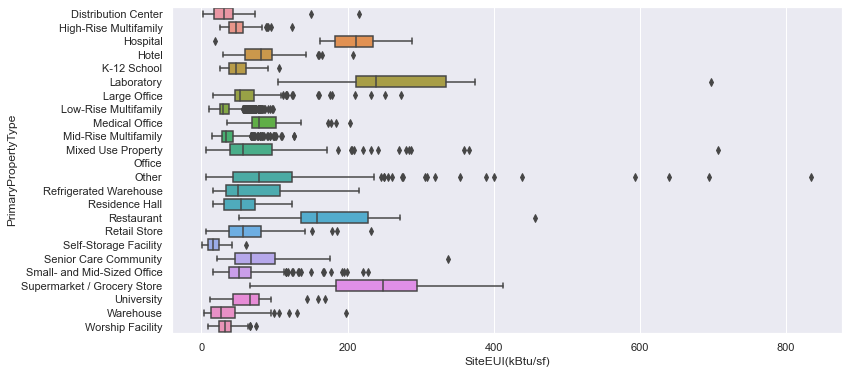

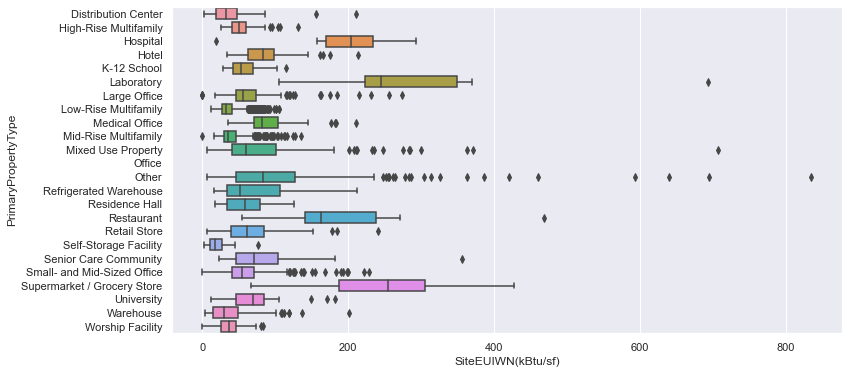

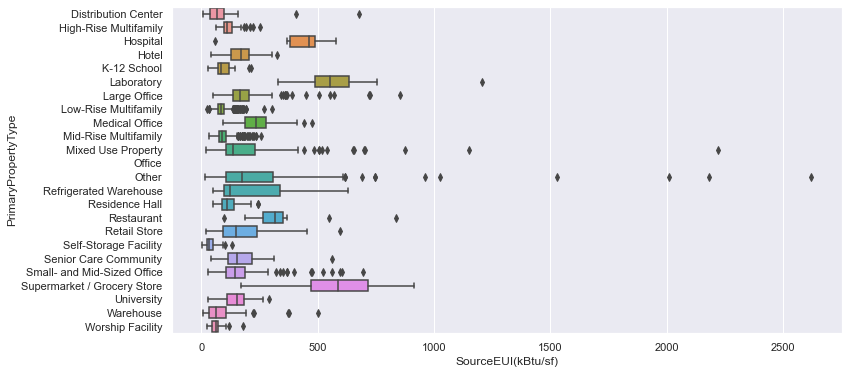

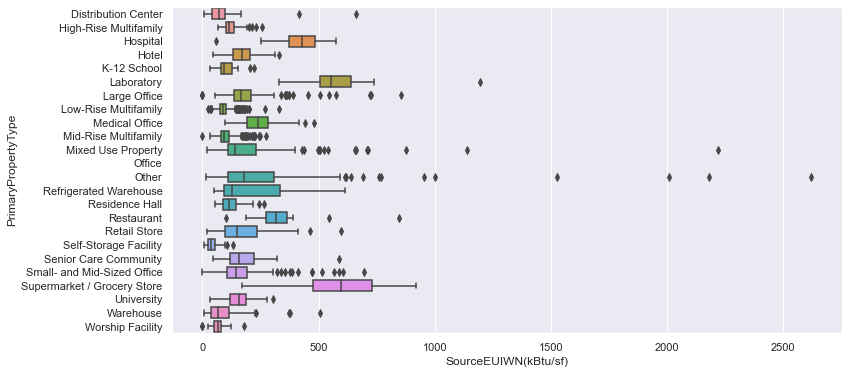

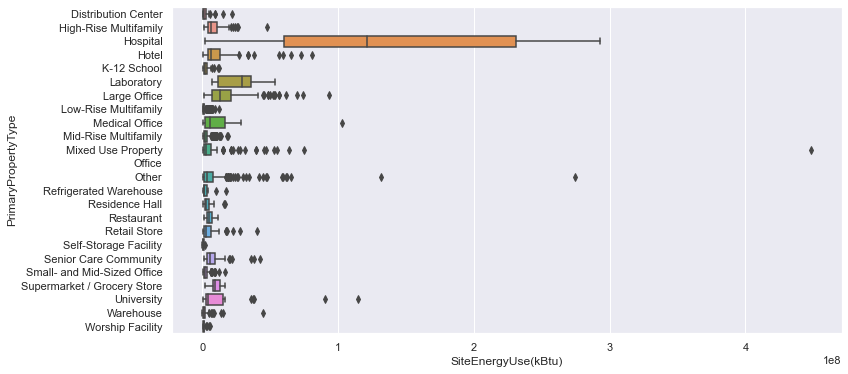

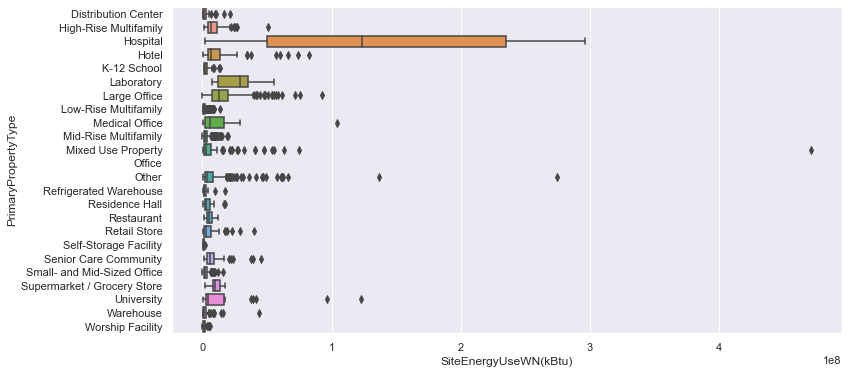

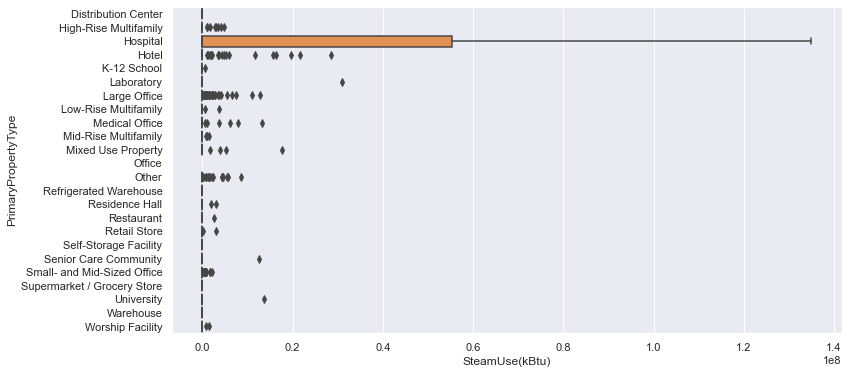

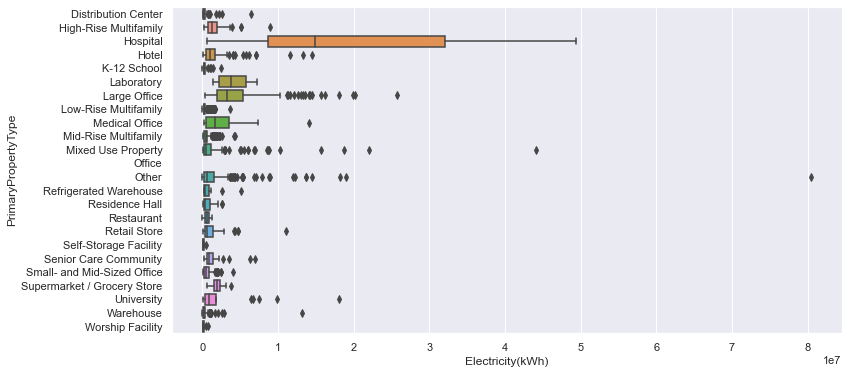

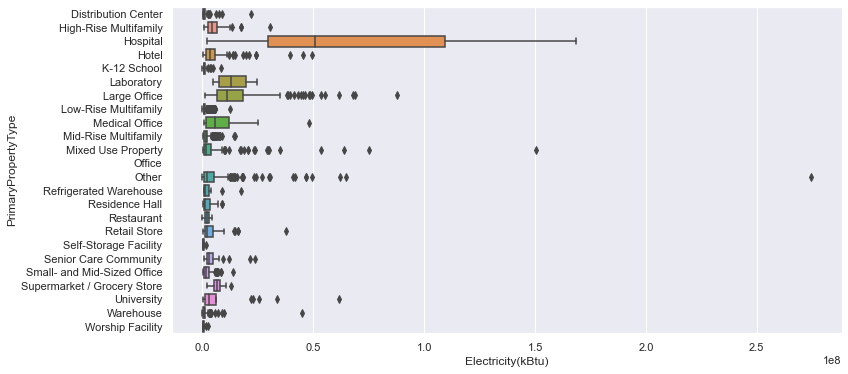

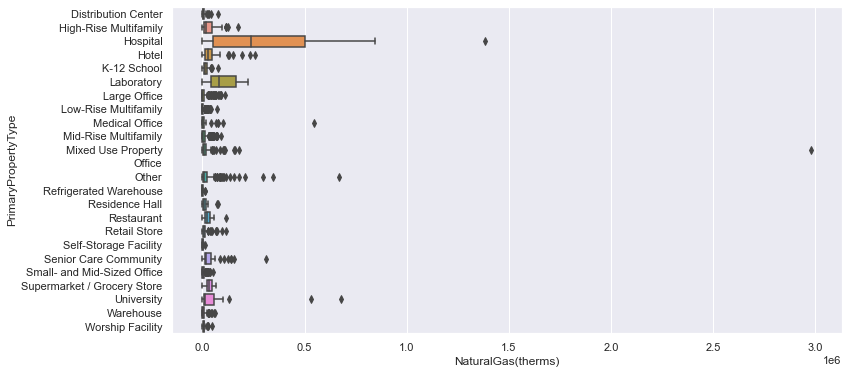

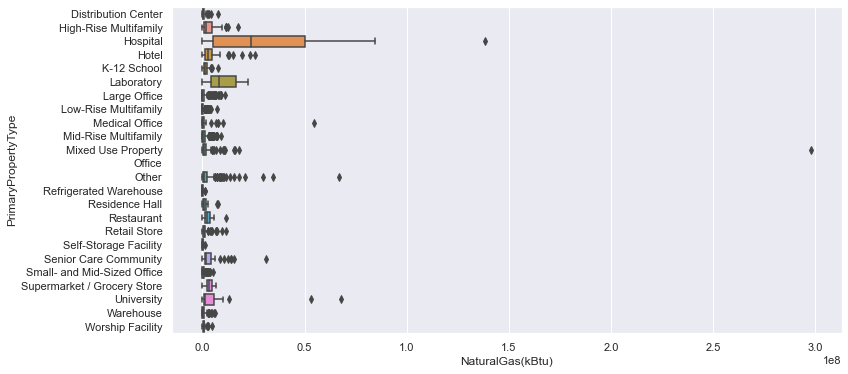

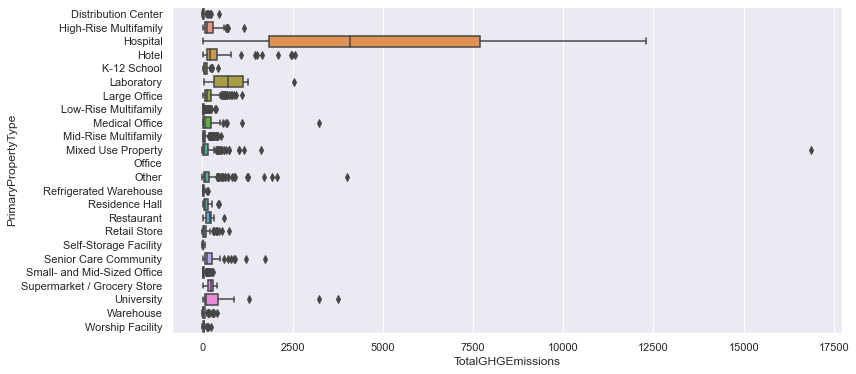

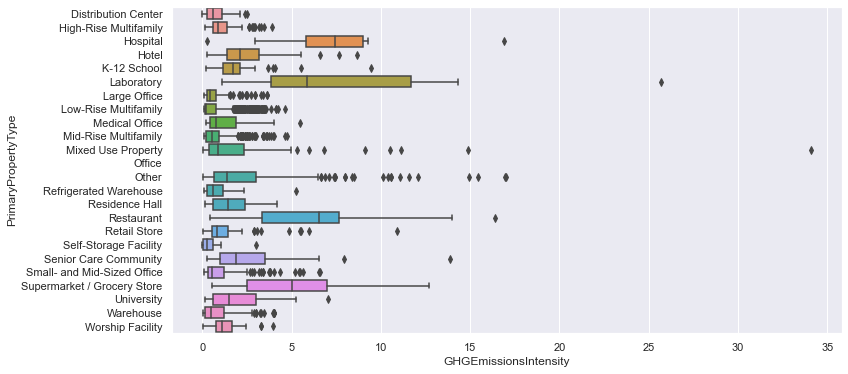

In [47]:
from functions import *

print("After removing outliers, we display boxplot per energy feature and per Primary Property Type.")
print("We suppose that a K-12 School has different energy needed compared to a hospital, so the boxplot must represent that difference.")

display_boxplot_per_feature(all_data_v8, all_energy_features, "PrimaryPropertyType")

data = all_data_v7.copy()
data.shape

print("We could see outliers with the boxplot, we count here the number of outliers per energy feature.")


total_buildings = all_data_v7.shape[0]
print(total_buildings)

for column in all_energy_features:
    "outliers aux extrémités des distributions"
    print(column)
    data.loc[data[column] > data[column].quantile(0.995)] = np.nan
    data.loc[data[column] < data[column].quantile(0.005)] = np.nan

print(data.shape)

data.info()

for column in all_energy_features:
    print('\n',column)
    print('Percentage of NaN : ', round(data[column].isna().sum() / data[column].shape[0] * 100), '%')
    print('Uniques : ', data[column].nunique())

#### 8.2) Outliers / Percentile 0.5% and Percentile 99.5%

##### Checking upper outliers and lower outliers

##### We remove the percentile  95 and percentile 5.
We remove the outliers which values for the Total Energy greater than the percentile 95 and lower than the percentile 5.

In [48]:
print("Before")
all_data_v8.info()

Before
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157 entries, 2258 to 3375
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3157 non-null   category
 1   BuildingType                     3157 non-null   category
 2   PrimaryPropertyType              3157 non-null   category
 3   ZipCode                          3157 non-null   category
 4   CouncilDistrictCode              3157 non-null   category
 5   Neighborhood                     3157 non-null   category
 6   YearBuilt                        3157 non-null   category
 7   NumberofBuildings                3157 non-null   float64 
 8   NumberofFloors                   3157 non-null   int64   
 9   PropertyGFATotal                 3157 non-null   int64   
 10  PropertyGFAParking               3157 non-null   int64   
 11  PropertyGFABuilding(s)           3157 non-null   int64   
 

In [49]:
print("After")
#all_data_v9 = remove_percentile_outliers(all_data_v8, 0.995, 0.005, ["SiteEnergyUse(kBtu)", "TotalGHGEmissions"])
all_data_v9 = all_data_v8.copy()
display(all_data_v9.info())

After
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3157 entries, 2258 to 3375
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   OSEBuildingID                    3157 non-null   category
 1   BuildingType                     3157 non-null   category
 2   PrimaryPropertyType              3157 non-null   category
 3   ZipCode                          3157 non-null   category
 4   CouncilDistrictCode              3157 non-null   category
 5   Neighborhood                     3157 non-null   category
 6   YearBuilt                        3157 non-null   category
 7   NumberofBuildings                3157 non-null   float64 
 8   NumberofFloors                   3157 non-null   int64   
 9   PropertyGFATotal                 3157 non-null   int64   
 10  PropertyGFAParking               3157 non-null   int64   
 11  PropertyGFABuilding(s)           3157 non-null   int64   
 1

None

C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\athen\Anaconda3\envs\P4_OC\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


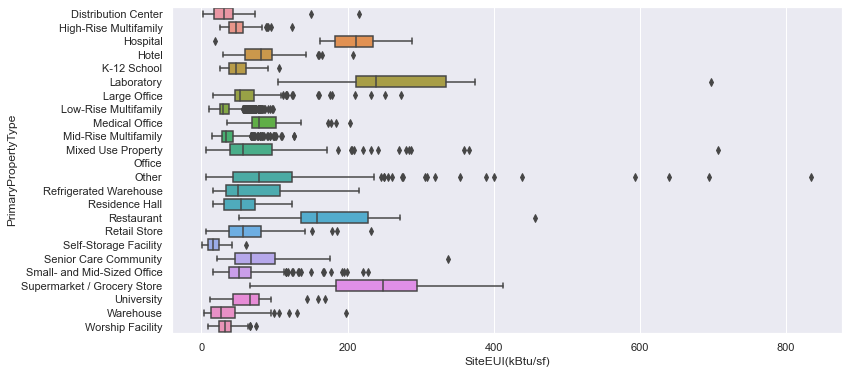

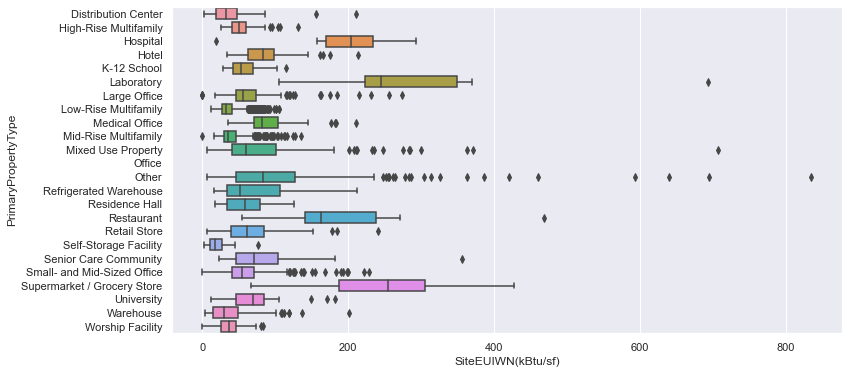

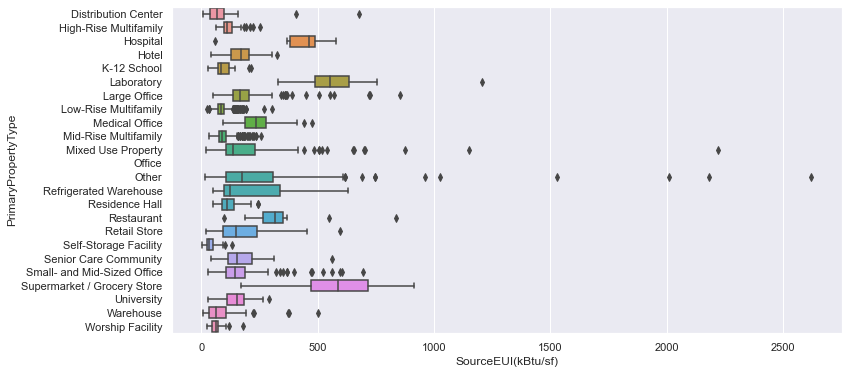

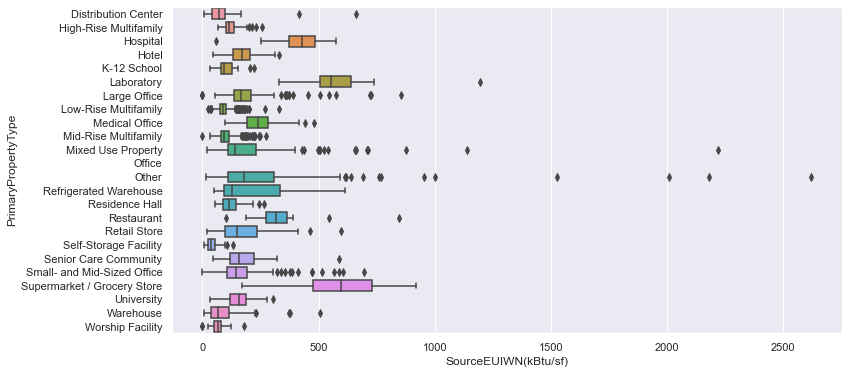

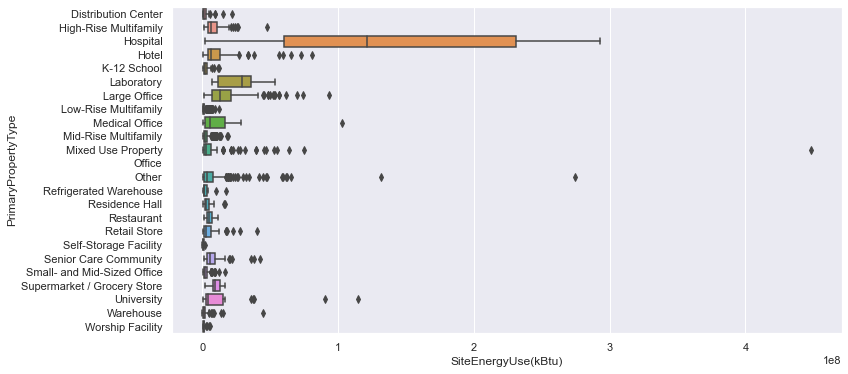

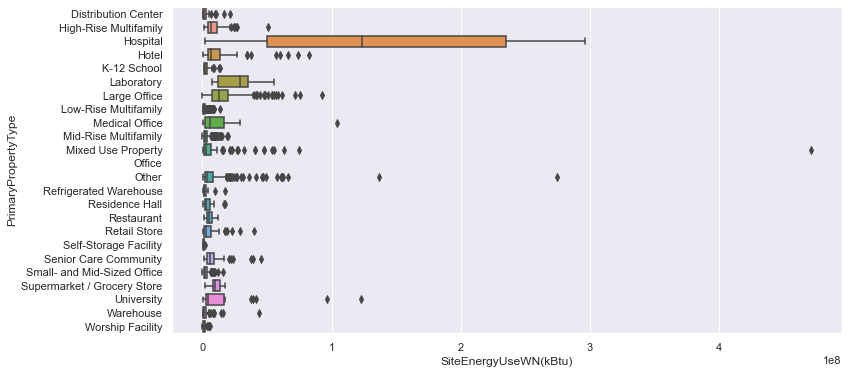

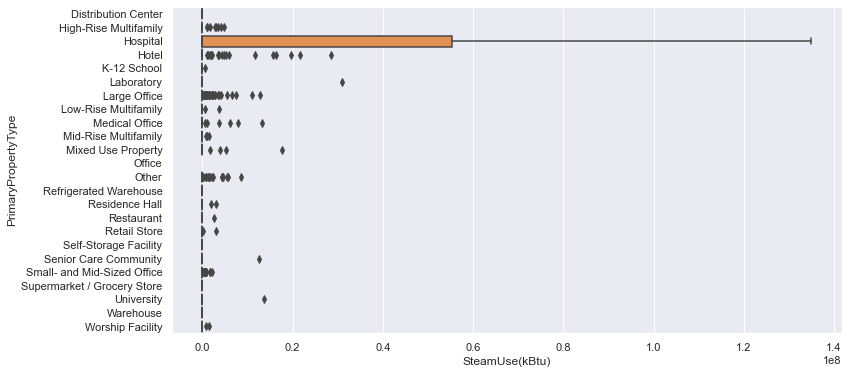

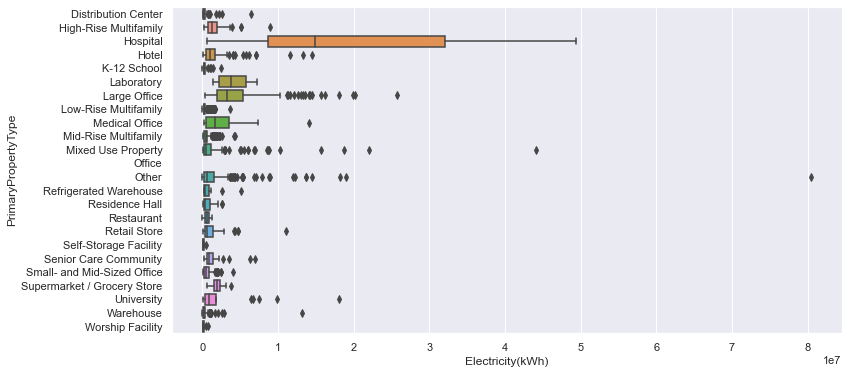

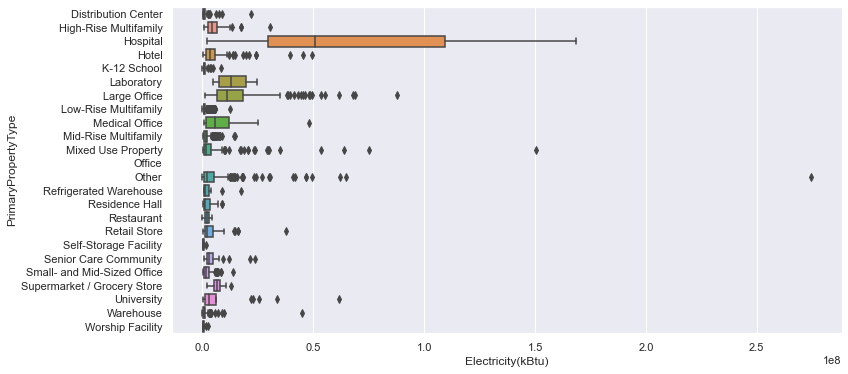

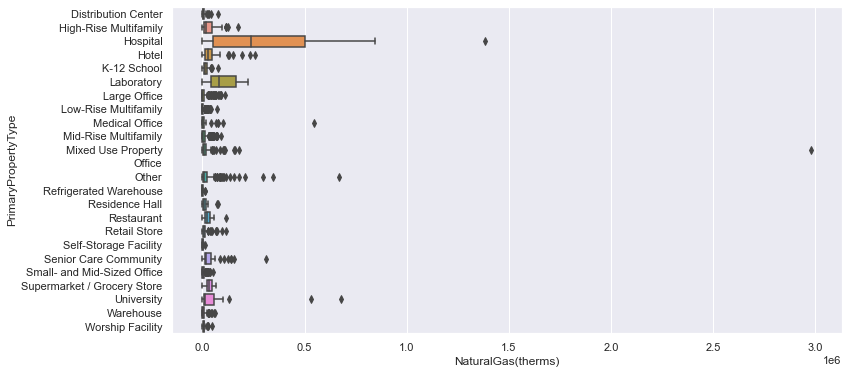

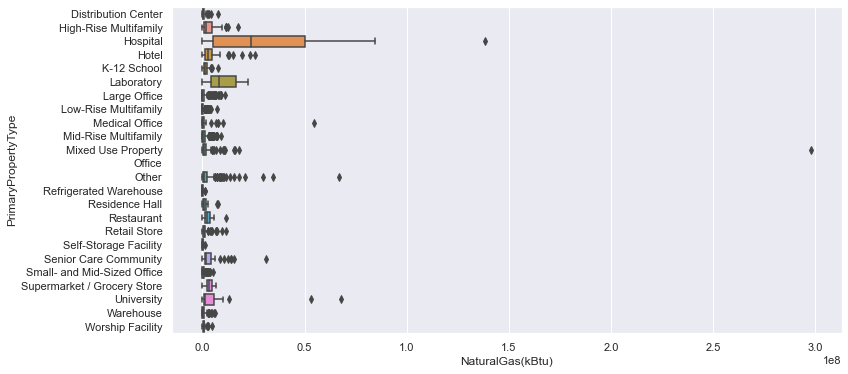

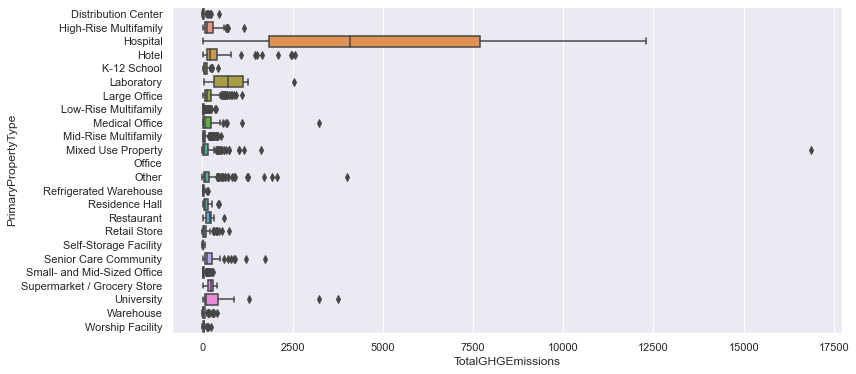

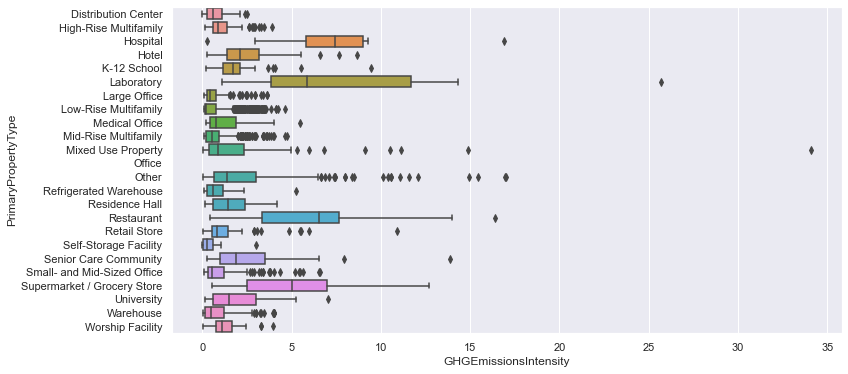

In [50]:
display_boxplot_per_feature(all_data_v9, all_energy_features, "PrimaryPropertyType")

#### 8.3) Saving final cleaned dataset

In [51]:
# We reset the index
all_data_vf = all_data_v9.reset_index(drop = True)

# Save
export_path = "./dataset/cleaned/"
export_filename = "2016_Building_Energy_Cleaned.csv"

all_data_vf.to_csv("{}{}".format(export_path, export_filename), index=False)